In [ ]:
# Cell 1: Install required libraries (if not already installed)
# Install required libraries
# Cell 1: Install required libraries (if not already installed)
%pip install numpy opencv-python h5py faiss-cpu sqlite3 matplotlib
%pip install  psycopg2 dotenv

In [ ]:
# THIS CELL DOWNLOADS IMAGES FROM SCRYFALL API

import os
import base64
import json
import time
import threading
import requests
import psycopg2
import psycopg2.extras
from dotenv import load_dotenv
from concurrent.futures import ThreadPoolExecutor, as_completed

# Try to import tqdm for progress indication, otherwise use a dummy iterator.
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, **kwargs: x

# ---------------------------
# CONFIGURATION
# ---------------------------
load_dotenv('.env')
DB_USER = os.getenv("POSTGRES_USER")
DB_PASSWORD = os.getenv("POSTGRES_PASSWORD")
DB_NAME = os.getenv("POSTGRES_DB")
DB_HOST = os.getenv("POSTGRES_HOST", "localhost")
DB_PORT = os.getenv("POSTGRES_PORT", "5432")

IMAGES_DIR = "images"
if not os.path.exists(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)

# Unwanted image prefix (first ~10 characters of a Base64 string)
UNWANTED_PREFIX = "/9j/4AAQSkZJRgABAQAAAQABAAD/2w"

# Rate limiting: at least 0.2 seconds between requests.
RATE_LIMIT_DELAY = 0.2
request_lock = threading.Lock()
last_request_time = 0.0

def connect_db():
    conn = psycopg2.connect(
        dbname=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD,
        host=DB_HOST,
        port=DB_PORT
    )
    return conn

def query_cards(conn):
    """
    Query for cards that meet the criteria:
      - layout != 'art_series'
      - games JSONB contains "paper"
    """
    query = """
        SELECT id, name, image_uris, card_faces, legalities, prints_search_uri, oracle_id
        FROM cards
        WHERE layout != 'art_series'
          AND games @> '["paper"]'
    """
    with conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor) as cur:
        cur.execute(query)
        return cur.fetchall()

def download_image(url, filepath):
    """
    Download an image from the URL and save it to the given filepath.
    This function enforces a delay between requests to avoid overloading the server.
    Returns True if successful, False otherwise.
    """
    global last_request_time
    try:
        # Rate limit: ensure at least RATE_LIMIT_DELAY seconds between requests.
        with request_lock:
            current = time.monotonic()
            elapsed = current - last_request_time
            if elapsed < RATE_LIMIT_DELAY:
                time.sleep(RATE_LIMIT_DELAY - elapsed)
            # Update the last request time.
            last_request_time = time.monotonic()
        
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            with open(filepath, 'wb') as f:
                f.write(response.content)
            return True
        else:
            print(f"Failed to download image: {url} (status code {response.status_code})")
    except Exception as e:
        print(f"Exception downloading {url}: {e}")
    return False

def image_has_unwanted_prefix(filepath):
    """
    Read the file and return True if its Base64 encoding starts with the unwanted prefix.
    """
    try:
        with open(filepath, 'rb') as f:
            data = f.read()
            b64_str = base64.b64encode(data).decode('utf-8')
            return b64_str.startswith(UNWANTED_PREFIX)
    except Exception as e:
        print(f"Error checking image {filepath}: {e}")
        return False

def all_faces_downloaded(card):
    """
    For a given card, return True if all expected face images exist.
    For multi-faced cards, check that each face file exists.
    For single-faced cards, check that the _0 file exists.
    """
    card_id = card["id"]
    if card.get("card_faces"):
        faces = card["card_faces"]
        for i in range(len(faces)):
            filepath = os.path.join(IMAGES_DIR, f"{card_id}_{i}.jpg")
            if not os.path.exists(filepath):
                return False
        return True
    else:
        filepath = os.path.join(IMAGES_DIR, f"{card_id}_0.jpg")
        return os.path.exists(filepath)

def process_single_card(card):
    """
    Process a single card object (either primary or alternative printing).
    Returns True if at least one image was successfully downloaded.
    """
    card_id = card["id"]
    image_downloaded = False

    # Skip if legalities exist and all statuses are "not_legal"
    legalities = card.get("legalities")
    if legalities:
        if isinstance(legalities, str):
            try:
                legalities = json.loads(legalities)
            except Exception as e:
                print(f"Error parsing legalities for card {card_id}: {e}")
                return False
        if all(status == "not_legal" for status in legalities.values()):
            return False

    # Multi-faced card
    if card.get("card_faces"):
        try:
            faces = card["card_faces"]
            for i, face in enumerate(faces):
                # Prefer face-specific image uris, fallback to card-level
                if face.get("image_uris"):
                    url = face["image_uris"].get("png") or face["image_uris"].get("large")
                else:
                    url = card.get("image_uris", {}).get("png") or card.get("image_uris", {}).get("large")
                if url:
                    filename = os.path.join(IMAGES_DIR, f"{card_id}_{i}.jpg")
                    if not os.path.exists(filename):
                        if download_image(url, filename):
                            if image_has_unwanted_prefix(filename):
                                print(f"Removing unwanted image: {filename}")
                                os.remove(filename)
                            else:
                                image_downloaded = True
        except Exception as e:
            print(f"Error processing card faces for {card_id}: {e}")
    else:
        # Single-faced card
        url = None
        if card.get("image_uris"):
            try:
                image_uris = json.loads(card["image_uris"]) if isinstance(card["image_uris"], str) else card["image_uris"]
                url = image_uris.get("png") or image_uris.get("large")
            except Exception as e:
                print(f"Error parsing image_uris for card {card_id}: {e}")
        if url:
            filename = os.path.join(IMAGES_DIR, f"{card_id}_0.jpg")
            if not os.path.exists(filename):
                if download_image(url, filename):
                    if image_has_unwanted_prefix(filename):
                        print(f"Removing unwanted image: {filename}")
                        os.remove(filename)
                    else:
                        image_downloaded = True
    return image_downloaded

def fetch_alternative_prints(card):
    """
    Fetch alternative printings for a card using prints_search_uri, or fallback via oracle_id.
    Returns a list of card objects.
    Includes a retry mechanism for handling timeouts and abnormal responses.
    """
    alt_prints = []
    uri = card.get("prints_search_uri")
    if not uri and card.get("oracle_id"):
        # Fallback: construct query URL using oracle_id
        oracle_id = card["oracle_id"]
        uri = f"https://api.scryfall.com/cards/search?order=released&q=oracleid%3A{oracle_id}&unique=prints"
    if uri:
        retries = 3
        while retries > 0:
            try:
                # Enforce rate limiting before the request.
                global last_request_time
                with request_lock:
                    current = time.monotonic()
                    elapsed = current - last_request_time
                    if elapsed < RATE_LIMIT_DELAY:
                        time.sleep(RATE_LIMIT_DELAY - elapsed)
                    last_request_time = time.monotonic()
                response = requests.get(uri, timeout=10)
                if response.status_code == 200:
                    data = response.json()
                    alt_prints = data.get("data", [])
                    break
                else:
                    print(f"Failed to fetch alternative prints for card {card['id']} (status code {response.status_code})")
                    break
            except Exception as e:
                retries -= 1
                print(f"Exception fetching alternative prints for card {card['id']}: {e} (retries left: {retries})")
                if retries == 0:
                    print(f"Max retries reached for card {card['id']}. Skipping alternative prints.")
                    break
                time.sleep(1)  # brief pause before retrying
    return alt_prints

def process_card_concurrent(card):
    """
    Process a single card, including its primary and alternative printings.
    Returns a list of mapping dictionaries for the card.
    """
    mappings = []
    primary_id = card["id"]
    card_name = card["name"]

    # Process primary printing.
    if not all_faces_downloaded(card):
        if process_single_card(card):
            mappings.append({"card_id": primary_id, "card_name": card_name})
    else:
        mappings.append({"card_id": primary_id, "card_name": card_name})

    # Process alternative printings.
    alt_prints = fetch_alternative_prints(card)
    for alt in alt_prints:
        alt_id = alt.get("id")
        # Skip if alternative print is the same as the primary printing.
        if alt_id == primary_id:
            continue
        # Check if alternative print is complete.
        if all_faces_downloaded(alt):
            continue
        if process_single_card(alt):
            alt_name = alt.get("name", card_name)
            mappings.append({"card_id": alt_id, "card_name": alt_name})
    return mappings

def process_cards_concurrently(cards, max_workers=8):
    """
    Process all cards concurrently using a thread pool.
    Returns a list of label mappings for every card processed (including reprints).
    """
    label_mappings = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_card_concurrent, card): card for card in cards}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing cards", unit="card"):
            try:
                card_mappings = future.result()
                label_mappings.extend(card_mappings)
            except Exception as e:
                print(f"Error processing a card: {e}")

    return label_mappings

def main():
    conn = connect_db()
    print("Querying cards from the database...")
    cards = query_cards(conn)
    print(f"Found {len(cards)} cards meeting criteria.")

    print("Downloading images concurrently for each card and alternative printings...")
    label_mappings = process_cards_concurrently(cards, max_workers=8)

    # The label_mappings list now contains an entry for every card (including reprints).
    # CSV writing has been removed. Handle CSV export in its own cell.
    print(f"Processed {len(label_mappings)} card printings (primary + reprints).")

    conn.close()
    print("Processing complete.")

if __name__ == "__main__":
    main()


In [7]:
# THIS CELL SETS UP THE SQLITE DATABASE

import os
import sqlite3

# Delete the existing database file if it exists.
db_file = 'card_database.db'
if os.path.exists(db_file):
    os.remove(db_file)
    print(f"Deleted existing database file: {db_file}")

# Create (or open) SQLite database for card metadata
conn = sqlite3.connect(db_file)
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE IF NOT EXISTS cards (
        scryfall_id TEXT,
        image_path TEXT,
        face_index INTEGER
    )
''')

# --- Main Dataset Population ---
dataset_path = 'images'  # Path where your main images are stored
limit = None             # Limit the number of main dataset entries for quick testing or set to 'None' for around 90k
count = 0

for filename in os.listdir(dataset_path):
    if filename.endswith('.jpg'):
        parts = filename.split('_')
        # Expecting filename format: "scryfall_id_faceindex.jpg"
        if len(parts) == 2 and parts[1].endswith('.jpg'):
            scryfall_id = parts[0]
            face_index = int(parts[1].split('.')[0])
            image_full_path = os.path.join(dataset_path, filename)
            cursor.execute('''
                INSERT INTO cards (scryfall_id, image_path, face_index)
                VALUES (?, ?, ?)
            ''', (scryfall_id, image_full_path, face_index))
            count += 1
            if limit is not None and count >= limit:
                break

# --- Extra Validation Entries added on top only for the reduced dataset ---
extra_entries = [
    ("38748fbe-0d3e-4697-b9c4-d93a4ac59f9a", "images/38748fbe-0d3e-4697-b9c4-d93a4ac59f9a_0.jpg", 0),
    ("04a09fe4-d7a0-4065-968d-0837c3eafda0", "images/04a09fe4-d7a0-4065-968d-0837c3eafda0_0.jpg", 0),
    ("b462e121-015c-49c4-838a-ab788f213322", "images/b462e121-015c-49c4-838a-ab788f213322_0.jpg", 0),
    ("b1986db3-dd6c-44f2-8d7a-a6b42d55a7c1", "images/b1986db3-dd6c-44f2-8d7a-a6b42d55a7c1_0.jpg", 0),
    ("63c5e1dd-2fe6-4734-8406-7bcdf17aa60c", "images/63c5e1dd-2fe6-4734-8406-7bcdf17aa60c_0.jpg", 0),
    ("6c7cfb9c-58e4-4f4a-9a2c-ba5a7ba34f03", "images/6c7cfb9c-58e4-4f4a-9a2c-ba5a7ba34f03_0.jpg", 0),
    # Note: if any field here is empty, the entry will be skipped.
    ("ee3768ec-bb3b-44dc-9fa3-7cb3d3ee9f8c", "images/ee3768ec-bb3b-44dc-9fa3-7cb3d3ee9f8c_0.jpg", 0),
    ("8321888a-a450-4c15-9461-255cfaa05367", "images/8321888a-a450-4c15-9461-255cfaa05367_0.jpg", 0),
    ("b5e8e2a9-8dcb-40dd-8079-6c8484c3b157", "images/b5e8e2a9-8dcb-40dd-8079-6c8484c3b157_0.jpg", 0)
]


# Insert extra validation entries only if they do not already exist and if the entry is populated.
for scryfall_id, image_path, face_index in extra_entries:
    # Skip entry if essential data is missing
    if not scryfall_id or not image_path:
        print(f"Skipping incomplete extra entry: scryfall_id={scryfall_id}, image_path={image_path}")
        continue

    cursor.execute('SELECT COUNT(*) FROM cards WHERE image_path = ?', (image_path,))
    exists = cursor.fetchone()[0]
    if exists == 0:
        cursor.execute('''
            INSERT INTO cards (scryfall_id, image_path, face_index)
            VALUES (?, ?, ?)
        ''', (scryfall_id, image_path, face_index))
    else:
        print(f"Entry for {image_path} already exists, skipping insertion.")

conn.commit()
conn.close()

print("Database populated with main dataset (limited) and extra validation entries (if not already present).")

Deleted existing database file: card_database.db
Database populated with main dataset (limited) and extra validation entries (if not already present).


In [ ]:
%pip install --upgrade jupyter ipywidgets
%jupyter nbextension enable --py widgetsnbextension

In [8]:
# THIS CELL WRITES THE INITAL CSV LABEL MAPPINGS > scryfall_id,image_path,face_index

import csv
import sqlite3

# Path to the SQLite database and the output CSV filename.
db_file = 'card_database.db'
csv_filename = 'label_mapping.csv'

# Connect to the SQLite database.
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# Select all card entries (including reprints) from the database.
cursor.execute("SELECT scryfall_id, image_path, face_index FROM cards")
rows = cursor.fetchall()

# Write the CSV label mapping.
# You can adjust the headers as needed. Here, we use scryfall_id, image_path, and face_index.
with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['scryfall_id', 'image_path', 'face_index'])
    writer.writerows(rows)

conn.close()

print("CSV label mapping written to", csv_filename)

CSV label mapping written to label_mapping.csv


In [ ]:
import cv2
import numpy as np
import sqlite3
import os
import json
from tqdm import tqdm
import faiss
import h5py

#########################
# Candidate Features Extraction and HDF5 Storage (Incremental, with Chunking and High Compression)
#########################

def serialize_keypoints(keypoints):
    return [{
        'pt': kp.pt,
        'size': kp.size,
        'angle': kp.angle,
        'response': kp.response,
        'octave': kp.octave,
        'class_id': kp.class_id
    } for kp in keypoints]

def extract_features_sift(image_path, max_features=100):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Unable to read image {image_path}")
    
    # Resize and preprocess image.
    resized = cv2.resize(image, (256, 256))
    lab = cv2.cvtColor(resized, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    L_clahe = clahe.apply(L)
    lab_clahe = cv2.merge((L_clahe, A, B))
    enhanced_color = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    gray = cv2.cvtColor(enhanced_color, cv2.COLOR_BGR2GRAY)
    
    # Create SIFT detector with max_features set to 100.
    sift = cv2.SIFT_create(nfeatures=max_features)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    if descriptors is not None and len(keypoints) > max_features:
        # Sort keypoints by response and take the top max_features.
        sorted_kp_des = sorted(zip(keypoints, descriptors), key=lambda x: -x[0].response)
        keypoints, descriptors = zip(*sorted_kp_des[:max_features])
        keypoints, descriptors = list(keypoints), np.array(descriptors)
    
    if descriptors is not None:
        eps = 1e-7
        descriptors = descriptors / (descriptors.sum(axis=1, keepdims=True) + eps)
        descriptors = np.sqrt(descriptors)
        # Convert to half precision to reduce file size.
        descriptors = descriptors.astype(np.float16)
    
    return keypoints, descriptors

# ---------------------------
# Delete old files if they exist
# ---------------------------
h5_features_file = 'candidate_features.h5'
faiss_index_file = 'faiss_ivf.index'
mapping_file = 'index_to_card.txt'
for file in [h5_features_file, faiss_index_file, mapping_file]:
    if os.path.exists(file):
        os.remove(file)
        print(f"Deleted existing file: {file}")

# Open HDF5 file with the default driver (data is written in chunks and compressed).
hf = h5py.File(h5_features_file, 'w')

# Retrieve image records from the database.
conn = sqlite3.connect('card_database.db')
cursor = conn.cursor()
cursor.execute('SELECT scryfall_id, image_path, face_index FROM cards')
rows = cursor.fetchall()
conn.close()

progress_bar = tqdm(total=len(rows), desc="Extracting features", unit="image")
expected_dim = 128  # SIFT descriptor dimension remains 128

# For each record, extract features and write directly to the HDF5 file.
for idx, (scryfall_id, image_path, face_index) in enumerate(rows):
    try:
        kp, des = extract_features_sift(image_path, max_features=100)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        progress_bar.update(1)
        continue

    if des is None:
        print(f"Warning: No descriptors for {image_path}")
        progress_bar.update(1)
        continue

    # Serialize keypoints into JSON.
    kp_serialized = serialize_keypoints(kp)
    kp_json = json.dumps(kp_serialized)
    
    # Create or retrieve group for this card.
    if scryfall_id in hf:
        card_grp = hf[scryfall_id]
    else:
        card_grp = hf.create_group(scryfall_id)
    
    # Create a subgroup for this extraction instance.
    feature_idx = len(card_grp)
    feat_grp = card_grp.create_group(f"feature_{feature_idx}")
    
    # Write keypoints as a 1D string dataset (wrapped in a list) with gzip compression at maximum level.
    dt = h5py.string_dtype(encoding="utf-8")
    feat_grp.create_dataset("keypoints", data=[kp_json], dtype=dt, compression="gzip", compression_opts=9, chunks=True)
    
    # Write descriptors as a numeric dataset with gzip compression (descriptors are stored as float16).
    feat_grp.create_dataset("descriptors", data=des, compression="gzip", compression_opts=9, chunks=True)
    
    progress_bar.update(1)
progress_bar.close()
hf.close()
print(f"Candidate features written to HDF5 file: {h5_features_file}")

#########################
# Incremental FAISS Index Building with Product Quantization (PQ)
#########################

# Pass 1: Sample a small number of descriptors for training.
sample_size = 1000  # Adjust as needed.
training_descriptors = []
with h5py.File(h5_features_file, 'r') as hf:
    for card_id in hf.keys():
        card_grp = hf[card_id]
        for feat_key in card_grp.keys():
            des = card_grp[feat_key]["descriptors"][()]
            training_descriptors.append(des)
            if len(training_descriptors) >= sample_size:
                break
        if len(training_descriptors) >= sample_size:
            break

if len(training_descriptors) > 0:
    training_sample = np.vstack(training_descriptors).astype('float32')
else:
    raise ValueError("No training descriptors available.")

d = training_sample.shape[1]  # Expected to be 128.
nlist = 100  # Number of clusters.
m = 8  # Number of subquantizers for PQ
bits = 8  # Bits per subquantizer

# Initialize FAISS index with Product Quantization (PQ).
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFPQ(quantizer, d, nlist, m, bits)
index.nprobe = 10  # Number of clusters to explore during search.
index.train(training_sample)
print("FAISS index trained with sample descriptors.")

# Pass 2: Incrementally add descriptors in batches and write mapping incrementally.
batch_size = 1000  # Adjust based on available memory.
batch_descriptors = []
# Open mapping file in append mode.
mf = open(mapping_file, 'w')

with h5py.File(h5_features_file, 'r') as hf:
    for card_id in hf.keys():
        card_grp = hf[card_id]
        for feat_key in card_grp.keys():
            des = card_grp[feat_key]["descriptors"][()]
            # For each descriptor (each row), add to the batch and immediately write its mapping.
            for dvec in des:
                batch_descriptors.append(dvec)
                mf.write(card_id + "\n")
            if len(batch_descriptors) >= batch_size:
                batch_np = np.vstack(batch_descriptors).astype('float32')
                index.add(batch_np)
                print(f"Added a batch of {batch_np.shape[0]} descriptors to the FAISS index.")
                batch_descriptors = []
    # Add any remaining descriptors.
    if len(batch_descriptors) > 0:
        batch_np = np.vstack(batch_descriptors).astype('float32')
        index.add(batch_np)
        print(f"Added final batch of {batch_np.shape[0]} descriptors to the FAISS index.")
mf.close()

# Save the FAISS index to disk.
faiss.write_index(index, faiss_index_file)
print(f"FAISS IVF index built with {index.ntotal} descriptors and saved to {faiss_index_file}.")
print(f"Index-to-card mapping written incrementally to {mapping_file}.")

Deleted existing file: candidate_features.h5
Deleted existing file: faiss_ivf.index
Deleted existing file: index_to_card.txt


Extracting features: 100%|██████████| 90051/90051 [51:59<00:00, 28.87image/s]  


Candidate features written to HDF5 file: candidate_features.h5
FAISS index trained with sample descriptors.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descriptors to the FAISS index.
Added a batch of 1000 descri

Evaluating images:   0%|          | 0/9 [00:00<?, ?it/s]

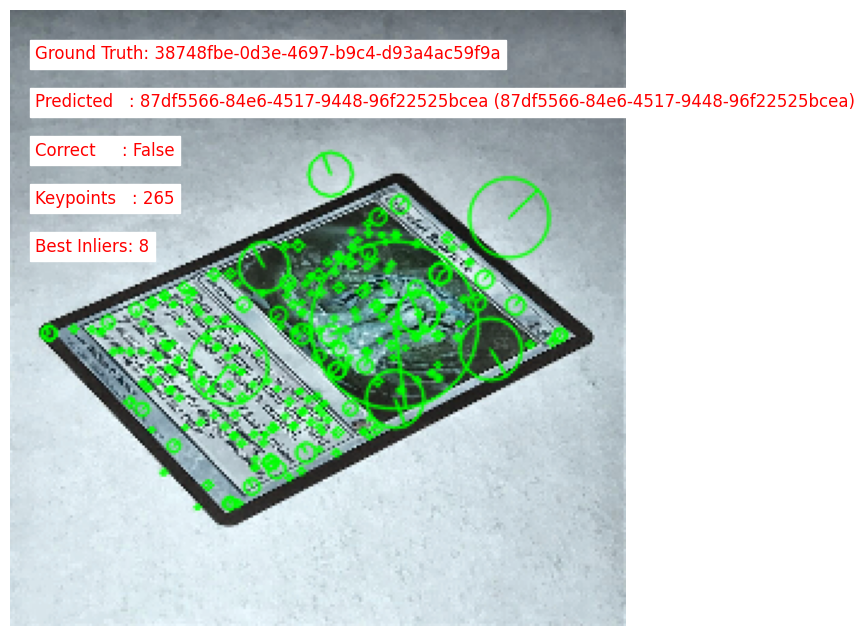

Evaluating images:  11%|█         | 1/9 [00:03<00:27,  3.39s/it]

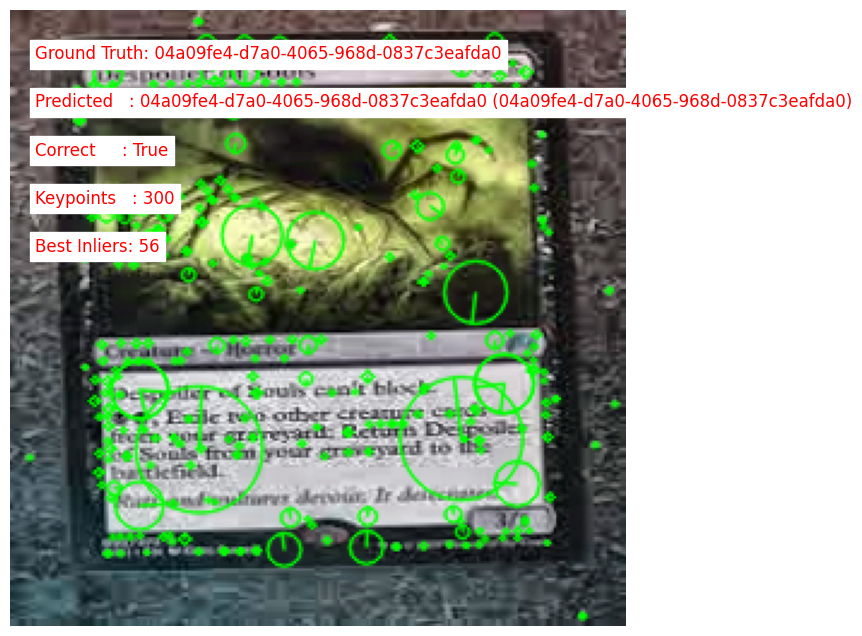

Evaluating images:  22%|██▏       | 2/9 [00:08<00:29,  4.19s/it]

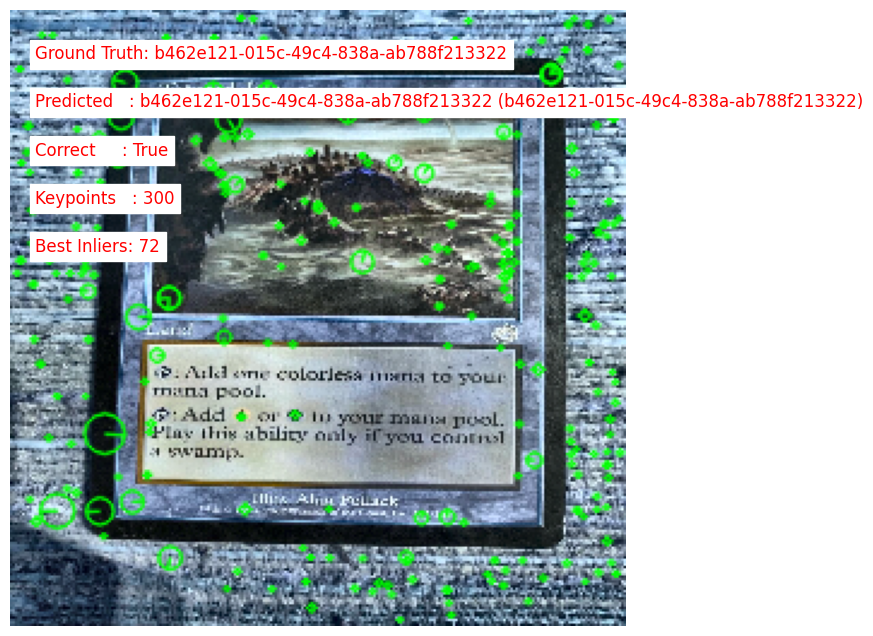

Evaluating images:  33%|███▎      | 3/9 [00:11<00:22,  3.73s/it]

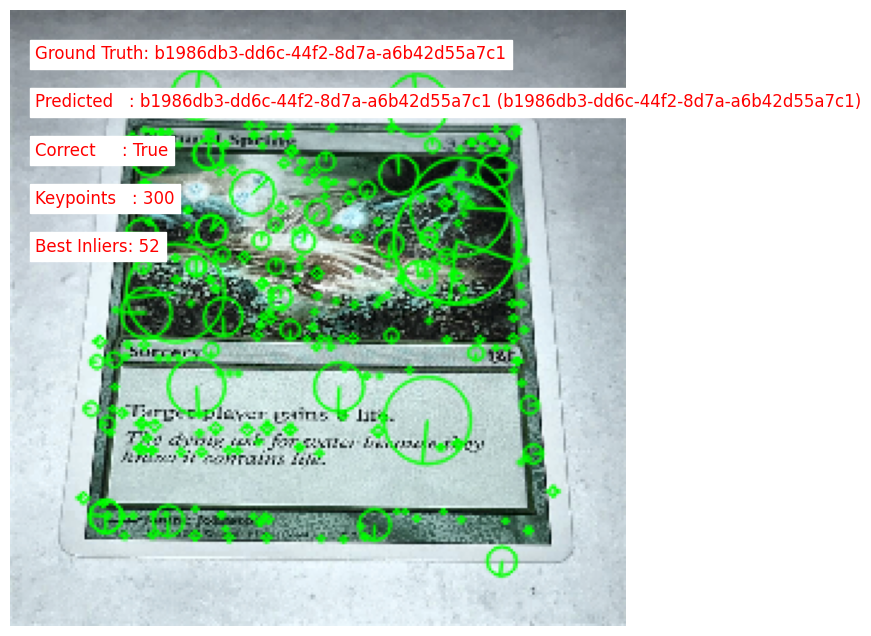

Evaluating images:  44%|████▍     | 4/9 [00:15<00:20,  4.01s/it]

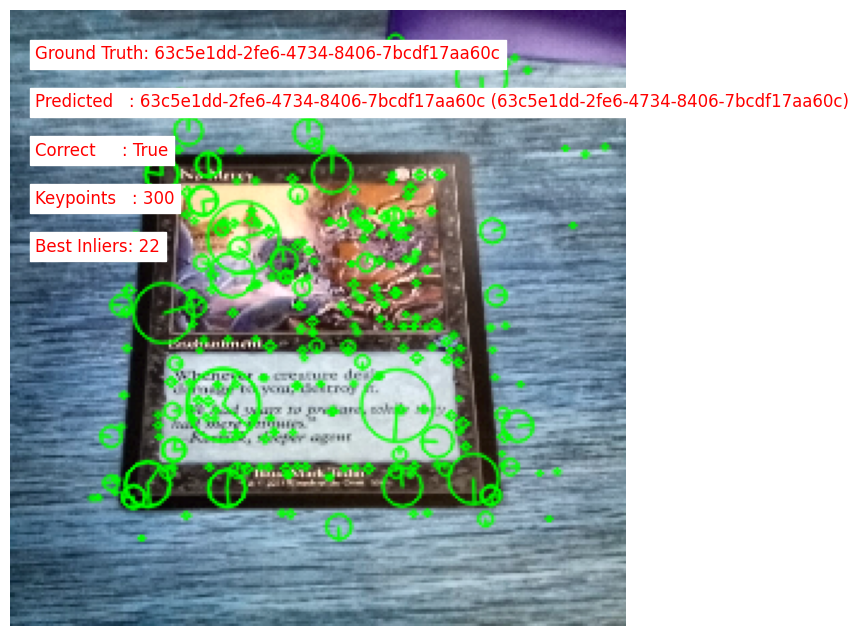

Evaluating images:  56%|█████▌    | 5/9 [00:19<00:15,  3.95s/it]

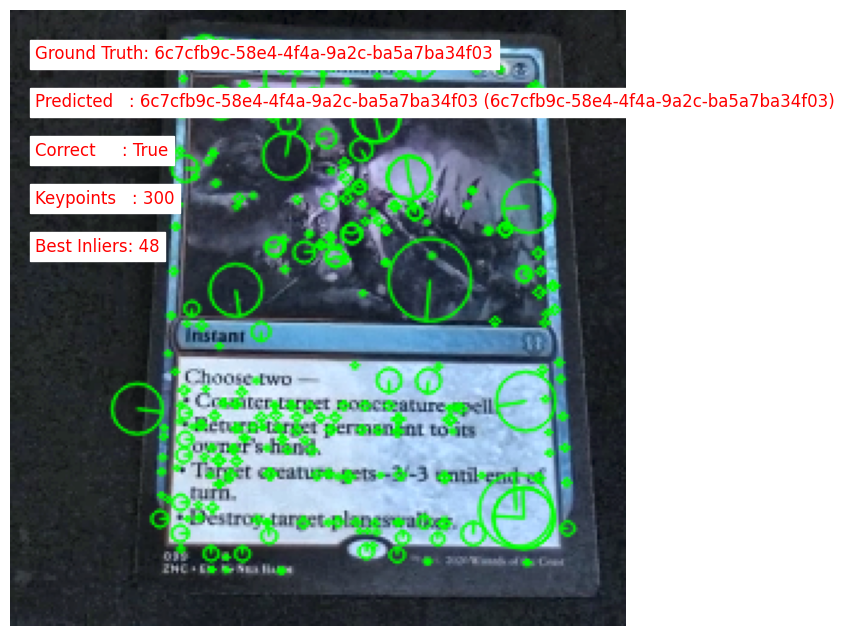

Evaluating images:  67%|██████▋   | 6/9 [00:25<00:13,  4.56s/it]

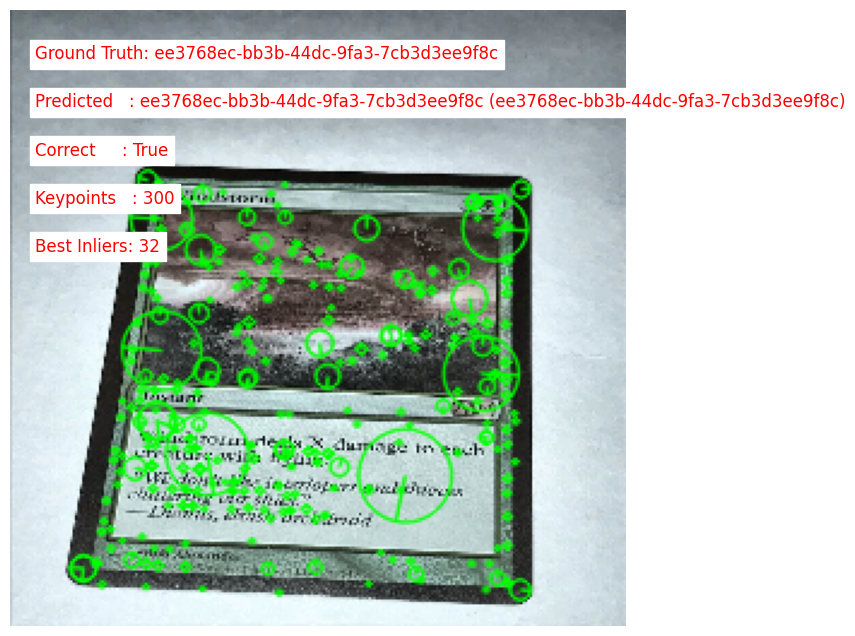

Evaluating images:  78%|███████▊  | 7/9 [00:29<00:09,  4.52s/it]

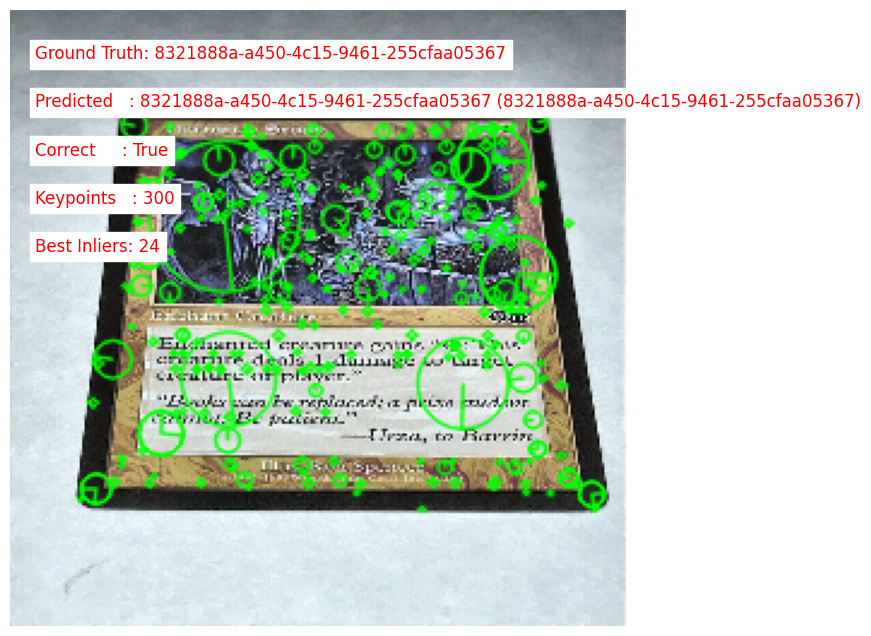

Evaluating images:  89%|████████▉ | 8/9 [00:33<00:04,  4.23s/it]

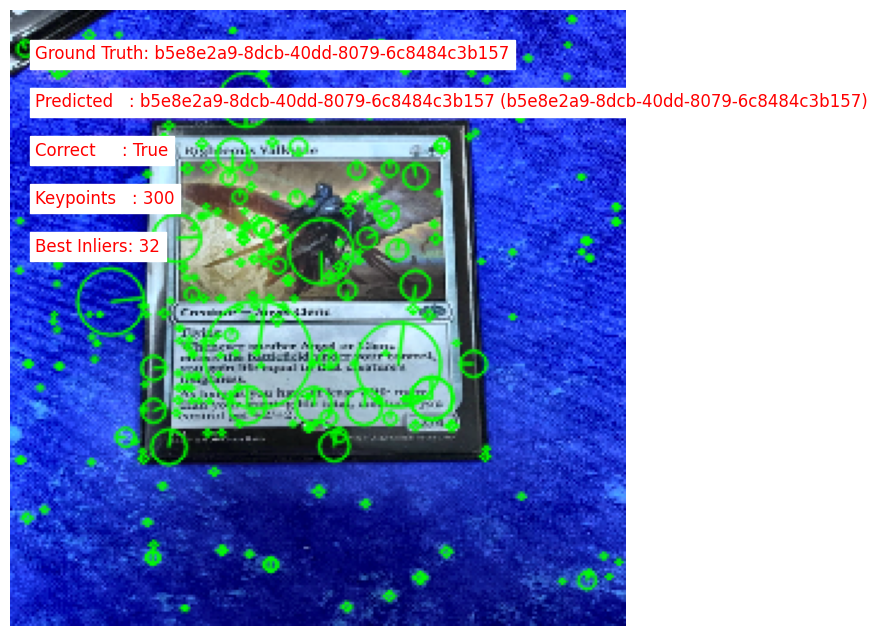

Evaluating images: 100%|██████████| 9/9 [00:37<00:00,  4.12s/it]

Overall Accuracy: 88.89% (8/9 correct)


In [10]:
import cv2
import numpy as np
import json
import pandas as pd
import faiss
import matplotlib.pyplot as plt
import h5py
from collections import Counter
from tqdm import tqdm

##############################
# Helper Functions for Candidate Features (HDF5)
##############################

def load_candidate_features_for_card(card_id, hf):
    """
    Given a card ID and an open HDF5 file (hf), load all candidate features for that card.
    Returns a list of tuples (kp_serialized, descriptors) with descriptors as float32.
    """
    features = []
    if card_id in hf:
        card_grp = hf[card_id]
        for feat_key in card_grp.keys():
            # Read keypoints: stored as a 1-element array of a UTF-8 encoded JSON string.
            kp_json_arr = card_grp[feat_key]["keypoints"][()]
            kp_str = kp_json_arr[0].decode("utf-8") if isinstance(kp_json_arr[0], bytes) else kp_json_arr[0]
            kp_serialized = json.loads(kp_str)
            # Read descriptors (stored as float16, converted back to float32 for matching).
            des = card_grp[feat_key]["descriptors"][()].astype('float32')
            features.append((kp_serialized, des))
    return features

##############################
# Load Persistent Data
##############################

# Open the HDF5 file containing candidate features.
hf = h5py.File('candidate_features.h5', 'r')

# Load label mapping CSV (should contain at least 'scryfall_id').
label_mapping = pd.read_csv('label_mapping.csv')

# Load the FAISS index. 
# Use a flat index for maximum accuracy (no quantization).
faiss_index = faiss.read_index("faiss_ivf.index")

# Load index-to-card mapping from text file.
with open('index_to_card.txt', 'r') as f:
    index_to_card = [line.strip() for line in f]

##############################
# Feature Extraction for Inference
##############################

def serialize_keypoints(keypoints):
    return [{
        'pt': kp.pt,
        'size': kp.size,
        'angle': kp.angle,
        'response': kp.response,
        'octave': kp.octave,
        'class_id': kp.class_id
    } for kp in keypoints]

def deserialize_keypoints(kps_data):
    keypoints = []
    for d in kps_data:
        kp = cv2.KeyPoint(d['pt'][0], d['pt'][1],
                          d['size'], d['angle'],
                          d['response'], d['octave'],
                          d['class_id'])
        keypoints.append(kp)
    return keypoints

def extract_features_sift(image_path, max_features=200):
    """
    For inference:
      1. Load the image and resize to 256x256.
      2. Convert to LAB, apply CLAHE on the L channel, then convert back to BGR.
      3. Convert to grayscale and extract SIFT features.
      4. Apply RootSIFT normalization.
    Returns keypoints, descriptors (as float32), and the preprocessed image.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Unable to read image {image_path}")
    
    resized = cv2.resize(image, (256,256))
    lab = cv2.cvtColor(resized, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    L_clahe = clahe.apply(L)
    lab_clahe = cv2.merge((L_clahe, A, B))
    enhanced_color = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    gray = cv2.cvtColor(enhanced_color, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create(nfeatures=max_features)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    if descriptors is not None and len(keypoints) > max_features:
        sorted_kp_des = sorted(zip(keypoints, descriptors), key=lambda x: -x[0].response)
        keypoints, descriptors = zip(*sorted_kp_des[:max_features])
        keypoints, descriptors = list(keypoints), np.array(descriptors)
    
    if descriptors is not None:
        eps = 1e-7
        descriptors = descriptors / (descriptors.sum(axis=1, keepdims=True) + eps)
        descriptors = np.sqrt(descriptors)
        descriptors = descriptors.astype('float32')
    
    return keypoints, descriptors, enhanced_color

##############################
# Inference Functions
##############################

def find_closest_card_ransac(image_path, faiss_index, index_to_card, hf, label_mapping, k=5):
    """
    Extracts SIFT features from the test image, searches for candidate matches in the FAISS index,
    loads candidate features from HDF5 on-demand, and uses BFMatcher+RANSAC to pick the best candidate.
    Returns the best candidate card ID, a display name, keypoints, the processed image, and debug info.
    """
    debug_info = {}
    keypoints, descriptors, processed_img = extract_features_sift(image_path, max_features=300)
    debug_info['num_keypoints'] = len(keypoints) if keypoints else 0
    if descriptors is None or len(keypoints) == 0:
        debug_info['error'] = "No descriptors found."
        return None, "Unknown", keypoints, processed_img, debug_info

    descriptors = descriptors.astype('float32')
    distances, indices = faiss_index.search(descriptors, k)
    candidate_ids = [index_to_card[i] for i in indices.flatten()]
    candidate_counts = Counter(candidate_ids)
    debug_info['faiss_candidate_counts'] = dict(candidate_counts)

    bf = cv2.BFMatcher()
    best_inliers = 0
    best_candidate = None

    for candidate_id in candidate_counts.keys():
        candidate_sets = load_candidate_features_for_card(candidate_id, hf)
        total_inliers = 0
        for kp_serialized, candidate_des in candidate_sets:
            candidate_kp = deserialize_keypoints(kp_serialized)
            matches = bf.knnMatch(descriptors, candidate_des.astype('float32'), k=2)
            good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
            if len(good_matches) >= 4:
                src_pts = np.float32([keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
                dst_pts = np.float32([candidate_kp[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
                H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                if mask is not None:
                    inliers = int(mask.sum())
                    total_inliers += inliers
        debug_info.setdefault('ransac_inliers', {})[candidate_id] = total_inliers
        if total_inliers > best_inliers:
            best_inliers = total_inliers
            best_candidate = candidate_id

    debug_info['best_inliers'] = best_inliers

    try:
        card_row = label_mapping.loc[label_mapping['scryfall_id'] == best_candidate]
        card_name = best_candidate if not card_row.empty else "Unknown"
    except Exception:
        card_name = "Unknown"

    return best_candidate, card_name, keypoints, processed_img, debug_info

def visualize_keypoints_on_resized(image_path, keypoints, processed_img, annotations=None, figsize=(10,8)):
    """
    Displays the processed image with keypoints overlaid.
    If the processed image is missing, attempts to reload and resize the original image.
    """
    if processed_img is None or processed_img.size == 0:
        processed_img = cv2.imread(image_path)
        if processed_img is None:
            print("Error: Could not load image for visualization.")
            return
        processed_img = cv2.resize(processed_img, (256,256))
    image_with_kp = cv2.drawKeypoints(processed_img, keypoints, None,
                                      color=(0,255,0),
                                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=figsize)
    plt.imshow(image_with_kp, cmap='gray')
    plt.axis('off')
    if annotations:
        y0, dy = 20, 20
        for i, text in enumerate(annotations):
            plt.text(10, y0 + i * dy, text, color='red', fontsize=12, backgroundcolor='white')
    plt.show()

def evaluate_accuracy_ransac(test_csv, faiss_index, index_to_card, hf, label_mapping, k=5):
    """
    Evaluates inference accuracy using a CSV file (with 'image_path' and 'true_card_id').
    For each test image, the predicted card is compared to the ground truth, and results are visualized.
    """
    test_data = pd.read_csv(test_csv)
    total = len(test_data)
    correct = 0
    predictions = []

    for idx, row in tqdm(test_data.iterrows(), total=total, desc="Evaluating images"):
        image_path = row['image_path']
        true_card_id = row['true_card_id']
        try:
            predicted_id, predicted_name, keypoints, processed_img, debug_info = find_closest_card_ransac(
                image_path, faiss_index, index_to_card, hf, label_mapping, k)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            predicted_id = None
            predicted_name = "Unknown"
            keypoints = []
            processed_img = None
            debug_info = {"error": str(e)}
        
        is_correct = predicted_id == true_card_id
        if is_correct:
            correct += 1
        predictions.append((image_path, true_card_id, predicted_id, debug_info))
        
        annotation_lines = [
            f"Ground Truth: {true_card_id}",
            f"Predicted   : {predicted_id} ({predicted_name})",
            f"Correct     : {is_correct}",
            f"Keypoints   : {debug_info.get('num_keypoints', 'N/A')}",
            f"Best Inliers: {debug_info.get('best_inliers', 'N/A')}"
        ]
        visualize_keypoints_on_resized(image_path, keypoints, processed_img, annotations=annotation_lines)
    
    accuracy = (correct / total) * 100
    print(f"Overall Accuracy: {accuracy:.2f}% ({correct}/{total} correct)")
    return predictions, accuracy

##############################
# Example Usage
##############################

test_csv_path = "test_dataset.csv"  # CSV with columns: image_path, true_card_id
predictions, accuracy = evaluate_accuracy_ransac(test_csv_path, faiss_index, index_to_card,
                                                 hf, label_mapping, k=5)

# Optionally close the HDF5 file when done.
hf.close()